In [1]:
# Created or modified on Sep 2023
# author: 임일
# KNN CF

import numpy as np
import pandas as pd

In [2]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('C:/RecoSys/Data/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings.drop('timestamp', axis=1)

In [3]:
# Rating 데이터를 test, train으로 나누고 train을 full matrix로 변환
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['user_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=12)
rating_matrix = x_train.pivot(values='rating', index='user_id', columns='movie_id')


In [4]:
# Train set의 모든 사용자 pair의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)


In [5]:
# RMSE 계산을 위한 함수
def RMSE(y_true, y_pred):
    import numpy as np
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

def score(model, k=20):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie, k) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

In [6]:
# Neighbor size를 고려하는 추천
def cf_knn(user_id, movie_id, neighbor_size=20):

    if movie_id in rating_matrix:

        # 현재 사용자와 다른 사용자 간의 similarity 가져오기
        sim_scores = user_similarity[user_id]
        # 현재 영화에 대한 모든 사용자의 rating값 가져오기
        movie_ratings = rating_matrix[movie_id]
        # 현재 영화를 평가하지 않은 사용자의 index 가져오기
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        # 현재 영화를 평가하지 않은 사용자의 rating (null) 제거
        movie_ratings = movie_ratings.drop(none_rating_idx)
        # 현재 영화를 평가하지 않은 사용자의 similarity값 제거
        sim_scores = sim_scores.drop(none_rating_idx)

        if neighbor_size == 0:               # Neighbor size가 지정되지 않은 경우
            # 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
            mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
        else:                                # Neighbor size가 지정된 경우
            # 지정된 neighbor size 값과 해당 영화를 평가한 총사용자 수 중 작은 것으로 결정
            neighbor_size = min(neighbor_size, len(sim_scores))
            # array로 바꾸기 (argsort를 사용하기 위함)
            sim_scores = np.array(sim_scores)
            movie_ratings = np.array(movie_ratings)
            # 유사도를 순서대로 정렬
            user_idx = np.argsort(sim_scores)
            # 유사도를 neighbor size만큼 받기
            # 오름차순으로 정렬했기 때문에 -@ 해야 유사도가 큰 사람을 고를 수 있음
            sim_scores = sim_scores[user_idx][-neighbor_size:]  
            # 영화 rating을 neighbor size만큼 받기
            movie_ratings = movie_ratings[user_idx][-neighbor_size:]
            # 최종 예측값 계산 
            mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()

    else:
        mean_rating = 3.0
    return mean_rating

score(cf_knn, 45)

1.010762129197404

#### 추천하기

In [7]:
# 추천을 위한 데이터 읽기 (추천을 위해서는 전체 데이터를 읽어야 함)
import pandas as pd
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('C:/RecoSys/Data/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings.drop('timestamp', axis=1)
rating_matrix = ratings.pivot(values='rating', index='user_id', columns='movie_id')

In [8]:
# 영화 제목 가져오기
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('C:/RecoSys/Data/u.item', sep='|', names=i_cols, encoding='latin-1')
movies = movies[['movie_id', 'title']]
movies = movies.set_index('movie_id')

In [9]:
# Cosine similarity 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

In [10]:
# 추천하기
def recommender(user, n_items=10, neighbor_size=20):
    # 현재 사용자의 모든 아이템에 대한 예상 평점 계산
    predictions = []
    rated_index = rating_matrix.loc[user][rating_matrix.loc[user] > 0].index    # 이미 평가한 영화 확인
    items = rating_matrix.loc[user].drop(rated_index)
    for item in items.index:
        predictions.append(cf_knn(user, item, neighbor_size))                   # 예상평점 계산
    recommendations = pd.Series(data=predictions, index=items.index, dtype=float)
    recommendations = recommendations.sort_values(ascending=False)[:n_items]    # 예상평점이 가장 높은 영화 선택
    recommended_items = movies.loc[recommendations.index]['title']
    return recommended_items

# 영화 추천 함수 부르기
recommender(2, 10, 45)

movie_id
1653    Entertaining Angels: The Dorothy Day Story (1996)
814                         Great Day in Harlem, A (1994)
1293                                      Star Kid (1997)
1536                                 Aiqing wansui (1994)
1189                                   Prefontaine (1997)
1122                       They Made Me a Criminal (1939)
1599                        Someone Else's America (1995)
1500                            Santa with Muscles (1996)
1201           Marlene Dietrich: Shadow and Light (1996) 
1467                 Saint of Fort Washington, The (1993)
Name: title, dtype: object

#### optimal size 구하기

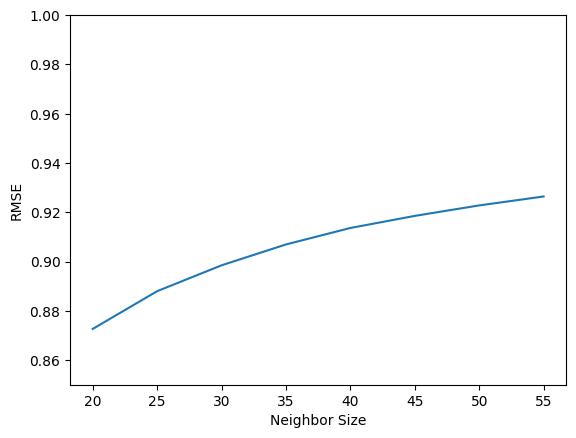

In [12]:
RMSE_by_K = []
Neighbor_size = []
for K in range(20, 60, 5):
    RMSE_by_K.append(score(cf_knn, K))
    Neighbor_size.append(K)
print(RMSE_by_K)

# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(Neighbor_size, RMSE_by_K)
plt.ylim(0.85, 1.)
plt.xlabel('Neighbor Size')
plt.ylabel('RMSE')
plt.show()